# 眼瞼・虹彩・瞳孔セグメンテーション 学習ノートブック

このノートブックでは、3つの手法（
1. 眼瞼1クラス＋楕円回帰、
2. 縁セグ、
3. 5クラス領域セグ
）の学習を実行します。


## GPU確認


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# GPUが利用可能か確認（必須）
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ GPUが利用可能です")
    print(f"  - デバイス: {torch.cuda.get_device_name(0)}")
    print(f"  - CUDA version: {torch.version.cuda}")
    print(f"  - PyTorch version: {torch.__version__}")
else:
    raise SystemError(
        "GPUが利用できません。CUDA対応のGPUと正しいドライバがインストールされているか確認してください。\n"
        "GPU版のPyTorchをインストールしてください: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124"
    )

print(f"\n使用デバイス: {device}")


✓ GPUが利用可能です
  - デバイス: NVIDIA GeForce RTX 3080 Ti Laptop GPU
  - CUDA version: 12.4
  - PyTorch version: 2.6.0+cu124

使用デバイス: cuda


## 必要なインポート


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import random
from datetime import datetime
import cv2
import pandas as pd

# 再現性のためにシードを設定
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
torch.cuda.manual_seed_all(GLOBAL_SEED)

print("必要なライブラリをインポートしました。")


必要なライブラリをインポートしました。


## 設定


In [3]:
# パス設定
IMAGES_DIR = Path("Images/images")
LABEL_SEG_DIR = Path("Images/labels_seg")
LABEL_OBB_DIR = Path("Images/labels_obb")
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(exist_ok=True)

# 学習設定
BATCH_SIZE = 16  # 512×512なので16に増やせる
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 30
IMAGE_SIZE = 512
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# 5-foldのインデックスを読み込み
with open('fold_indices.json', 'r') as f:
    fold_indices = json.load(f)

print(f"画像ディレクトリ: {IMAGES_DIR}")
print(f"モデル保存先: {MODEL_DIR}")
print(f"バッチサイズ: {BATCH_SIZE}")
print(f"最大エポック数: {NUM_EPOCHS}")
print(f"学習率: {LEARNING_RATE}")


画像ディレクトリ: Images\images
モデル保存先: model
バッチサイズ: 16
最大エポック数: 50
学習率: 0.001


In [4]:
# === このセルは無効化されました ===
# モデル初期化は、モデル定義とエイリアス定義の後（Cell 18以降）で実行されます
# Run Allで実行する場合、モデル定義セル（Cell 17）とエイリアス定義セル（Cell 18）を
# 先に実行した後、モデル初期化セルが実行されます
print("このセルは実行不要です。モデル定義セル（Cell 17）の後で初期化が行われます。")


このセルは実行不要です。モデル定義セル（Cell 17）の後で初期化が行われます。


## データセットの実装

3つの手法で使用するデータセット：
1. **方法1**: 眼瞼セグメンテーション + 楕円回帰
2. **方法2**: 縁セグメンテーション
3. **方法3**: 5クラス領域セグメンテーション


In [5]:
class EyeSegmentationDataset(Dataset):
    """
    眼瞼・虹彩・瞳孔セグメンテーションデータセット
    
    Attributes:
        image_paths: 画像のパスリスト
        label_seg_paths: セグメンテーションラベルのパス
        label_obb_paths: 楕円ラベルのパス
        transform: 変換関数
    """
    
    def __init__(self, image_paths, label_seg_dir, label_obb_dir, transform=None):
        self.image_paths = image_paths
        self.label_seg_dir = Path(label_seg_dir)
        self.label_obb_dir = Path(label_obb_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 画像を読み込み
        image_path = self.image_paths[idx]
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # リサイズ（640x640に統一）
        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_LINEAR)
        
        # ファイル名からベース名を取得
        filename_base = image_path.stem
        
        # ラベルを読み込み（6クラスPNGを使用）
        mask_lid = cv2.imread(str(self.label_seg_dir / f"{filename_base}_mask_lid.png"), 0)
        mask_iris = cv2.imread(str(self.label_obb_dir / f"{filename_base}_mask_iris.png"), 0)
        mask_pupil = cv2.imread(str(self.label_obb_dir / f"{filename_base}_mask_pupil.png"), 0)
        sixcls_path = self.label_seg_dir / f"{filename_base}_sixcls.png"
        sixcls = cv2.imread(str(sixcls_path), 0)
        
        # sixclsが見つからない場合の警告（最初の1回のみ）
        if sixcls is None and idx == 0:
            print(f"WARNING: sixcls file not found: {sixcls_path}")
            print("Please run the first cell of process_data.ipynb to generate sixcls labels!")
        
        # マスクも512x512にリサイズ（Noneはゼロ配列でフォールバック）
        def resize_mask(mask):
            if mask is None:
                return np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint8)
            return cv2.resize(mask, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        mask_lid = resize_mask(mask_lid)
        mask_iris = resize_mask(mask_iris)
        mask_pupil = resize_mask(mask_pupil)
        sixcls = resize_mask(sixcls)
        
        # データ拡張・Tensor変換（sixclsは不要なので除外）
        if self.transform:
            image, mask_lid, mask_iris, mask_pupil, _ = self.transform(
                image, mask_lid, mask_iris, mask_pupil, sixcls
            )
        else:
            # transformなしの場合：Tensorに変換
            # 画像はHWCからCHWに変換
            image = torch.from_numpy(image).float().permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
            image = image / 255.0
            mean = torch.tensor([0.485, 0.456, 0.406])
            std = torch.tensor([0.229, 0.224, 0.225])
            image = (image - mean[:, None, None]) / std[:, None, None]
            
            mask_lid = torch.from_numpy(mask_lid).long()
            mask_iris = torch.from_numpy(mask_iris).long()
            mask_pupil = torch.from_numpy(mask_pupil).long()
            # sixclsは返り値に含めないため、変換不要
        
        return {
            'image': image,
            'mask_lid': mask_lid,
            'mask_iris': mask_iris,
            'mask_pupil': mask_pupil,
            'filename': image_path.name
        }

print("データセットクラスを定義しました")


データセットクラスを定義しました


## データ拡張とデータローダー


In [6]:
import cv2
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

def get_augmentation(is_train=True):
    """
    データ拡張関数
    
    Args:
        is_train: 学習時はTrue、検証時はFalse
    
    Returns:
        transform関数
    """
    import numpy as np
    import random
    from scipy.ndimage import rotate
    
    def transform(image, *masks):
        # NumPy配列からTensorに変換（まだHWC形式）
        image_np = image.copy()
        masks_list = [m.copy() for m in masks]
        
        # ===== データ拡張（学習時のみ） =====
        if is_train:
            # Horizontal Flip（50%の確率）
            if random.random() < 0.5:
                image_np = np.fliplr(image_np).copy()  # copy()で負のストライドを解消
                masks_list = [np.fliplr(m).copy() for m in masks_list]  # copy()で負のストライドを解消
            
            # Rotate ±7°（30%の確率）
            if random.random() < 0.3:
                angle = random.uniform(-7, 7)
                # 画像は双3次補間、マスクは最近傍補間
                image_np = rotate(image_np, angle, axes=(0, 1), reshape=False, order=1, mode='reflect')
                masks_list = [rotate(m, angle, axes=(0, 1), reshape=False, order=0, mode='reflect') for m in masks_list]
            
            # 弱いColorJitter（20%の確率）
            if random.random() < 0.2:
                # brightness: 0.9-1.1
                brightness_factor = random.uniform(0.9, 1.1)
                image_np = np.clip(image_np * brightness_factor, 0, 255)
                
                # contrast: 0.9-1.1
                contrast_factor = random.uniform(0.9, 1.1)
                mean = image_np.mean()
                image_np = np.clip((image_np - mean) * contrast_factor + mean, 0, 255)
        
        # Tensorに変換（必ず.copy()を使用）
        image = torch.from_numpy(image_np.copy()).float()
        
        # HWCからCHWに変換
        image = image.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
        
        # 正規化（共通）
        image = image / 255.0
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = (image - mean[:, None, None]) / std[:, None, None]
        
        # 軽いCutout（学習時のみ、10%の確率）
        if is_train and random.random() < 0.1:
            # 10x10の小さなCutout
            h, w = image.shape[1], image.shape[2]
            h_cut, w_cut = 10, 10
            h_start = random.randint(0, max(0, h - h_cut))
            w_start = random.randint(0, max(0, w - w_cut))
            image[:, h_start:h_start+h_cut, w_start:w_start+w_cut] = (torch.tensor([0.485, 0.456, 0.406])[:, None, None] - mean[:, None, None]) / std[:, None, None]
        
        # マスクをTensorに変換（必ず.copy()を使用）
        masks_tensor = tuple(torch.from_numpy(m.copy()).long() for m in masks_list)
        return (image,) + masks_tensor
    
    return transform

# 画像パスの読み込み
df = pd.read_csv('image_metadata.csv')
image_paths = [IMAGES_DIR / row['filename'] for _, row in df.iterrows()]

print(f"画像数: {len(image_paths)}")
print(f"最初の5件: {image_paths[:5]}")


画像数: 1992
最初の5件: [WindowsPath('Images/images/1-20141126-38-091804_eb568e2ac952f8be45ec0ac9ae800120b7c988b60ac499ca87306986d218f554_L.jpg'), WindowsPath('Images/images/1-20141126-38-091804_eb568e2ac952f8be45ec0ac9ae800120b7c988b60ac499ca87306986d218f554_R.jpg'), WindowsPath('Images/images/1-20150121-38-142903_6e60b2355e174936406b708cf171e424300de779d4b8ae8e3aebb1a9de9905e6_L.jpg'), WindowsPath('Images/images/1-20150121-38-142903_6e60b2355e174936406b708cf171e424300de779d4b8ae8e3aebb1a9de9905e6_R.jpg'), WindowsPath('Images/images/1-20150121-38-142903_f27c8cf98eef934c557ffb70fed94b3fb9d400f29f472f2687b7fcec96e92c77_L.jpg')]


## データローダーの作成（fold別）


In [7]:
# Fold 0のデータローダーを作成（テスト用）
fold_idx = 0
train_indices = fold_indices[f'{fold_idx}']['train']
val_indices = fold_indices[f'{fold_idx}']['val']

train_paths = [image_paths[i] for i in train_indices]
val_paths = [image_paths[i] for i in val_indices]

# データセット作成
train_dataset = EyeSegmentationDataset(
    train_paths,
    LABEL_SEG_DIR,
    LABEL_OBB_DIR,
    transform=get_augmentation(is_train=True)
)

val_dataset = EyeSegmentationDataset(
    val_paths,
    LABEL_SEG_DIR,
    LABEL_OBB_DIR,
    transform=get_augmentation(is_train=False)
)

# データローダー作成
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Fold {fold_idx}:")
print(f"  Train: {len(train_dataset)}件")
print(f"  Val: {len(val_dataset)}件")
print(f"  バッチサイズ: {BATCH_SIZE}")


Fold 0:
  Train: 1593件
  Val: 399件
  バッチサイズ: 16


## U-Netアーキテクチャ（VGG16-BN encoder）


In [8]:
# U-Net型モデルは以下のセルで定義されています


## 3手法のモデル実装（U-Net版）

### 方法1: 眼瞼セグ1クラス + 楕円回帰
### 方法2: 縁セグメンテーション
### 方法3: 6クラス領域セグメンテーション


In [9]:
## U-Net型モデルの実装（EllSegスタイル、640解像度で推論）

class UNetEncoder(nn.Module):
    """VGG16ベースのエンコーダ（U-Net用）"""
    def __init__(self):
        super().__init__()
        from torchvision.models import vgg16_bn
        
        vgg = vgg16_bn(weights='DEFAULT')
        # VGG16の特徴抽出層
        self.features = vgg.features
        
        # ダウンステージの出力を記録
        # features[5]  : 64ch, 1/2
        # features[12] : 128ch, 1/4
        # features[22] : 256ch, 1/8
        # features[32] : 512ch, 1/16
        # features[43] : 512ch (maxpool後) → 実際には1024chの可能性も
        
    def forward(self, x):
        """マルチスケール特徴を抽出"""
        features = {}
        
        for i, layer in enumerate(self.features):
            x = layer(x)
            # 各スケールを記録
            if i == 5:  # conv2_2 (64ch)
                features['0'] = x
            elif i == 12:  # conv3_3 (128ch)
                features['1'] = x
            elif i == 22:  # conv4_3 (256ch)
                features['2'] = x
            elif i == 32:  # conv5_3 (512ch)
                features['3'] = x
        
        # 最上位層
        features['4'] = x  # 実際は512ch
        
        return features


class UNetDecoder(nn.Module):
    """U-Netデコーダ（512解像度で推論）"""
    def __init__(self, in_channels=512, out_channels=128):
        super().__init__()
        
        # 各スケールでのデコーダブロック
        # 4 -> 3: 512ch (upsampled) + 512ch (skip) = 1024ch → 256ch
        self.dec4 = self._make_block(512 + 512, 256)
        # 3 -> 2: 256ch + 256ch = 512ch → 128ch
        self.dec3 = self._make_block(256 + 256, 128)
        # 2 -> 1: 128ch + 128ch = 256ch → 64ch
        self.dec2 = self._make_block(128 + 128, 64)
        # 1 -> 0: 64ch + 64ch = 128ch → 64ch
        self.dec1 = self._make_block(64 + 64, 64)
        
    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, encoder_features):
        """
        Args:
            encoder_features: dict {'0': ..., '1': ..., ..., '4': ...}
        Returns:
            decoded: 512x512に近い解像度の特徴マップ
        """
        # 最上位から開始
        x = encoder_features['4']  # 512ch (VGG16-bnの最終)
        
        # Upsample -> Concat -> Decode
        x = torch.nn.functional.interpolate(x, size=encoder_features['3'].shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, encoder_features['3']], dim=1)  # (B, 512+512, H/16, W/16)
        x = self.dec4(x)  # -> 256ch, H/16
        
        x = torch.nn.functional.interpolate(x, size=encoder_features['2'].shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, encoder_features['2']], dim=1)  # (B, 256+256, H/8, W/8)
        x = self.dec3(x)  # -> 128ch, H/8
        
        x = torch.nn.functional.interpolate(x, size=encoder_features['1'].shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, encoder_features['1']], dim=1)  # (B, 128+128, H/4, W/4)
        x = self.dec2(x)  # -> 64ch, H/4
        
        x = torch.nn.functional.interpolate(x, size=encoder_features['0'].shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, encoder_features['0']], dim=1)  # (B, 64+64, H/2, W/2)
        x = self.dec1(x)  # -> 64ch, H/2
        
        # 最後に512x512へアップサンプリング
        x = torch.nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)
        
        return x  # (B, 64, 512, 512)


class UNetMethod1(nn.Module):
    """方法1: 眼瞼セグ1クラス + 楕円回帰（U-Net版）"""
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.encoder = UNetEncoder()
        self.decoder = UNetDecoder()
        
        # ヘッド
        self.eyelid_head = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )
        self.iris_ellipse_head = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 5)  # cx, cy, a, b, theta
        )
        self.pupil_ellipse_head = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 5)
        )
    
    def forward(self, x):
        # 640x640 -> 各スケールの特徴
        encoder_features = self.encoder(x)
        
        # デコーダで高解像度特徴に復元
        decoded = self.decoder(encoder_features)  # (B, 64, 640, 640)
        
        # 各ヘッド
        eyelid_seg = self.eyelid_head(decoded)
        iris_ellipse = self.iris_ellipse_head(decoded)
        pupil_ellipse = self.pupil_ellipse_head(decoded)
        
        return {
            'eyelid_seg': eyelid_seg,
            'iris_ellipse': iris_ellipse,
            'pupil_ellipse': pupil_ellipse
        }


class UNetMethod2(nn.Module):
    """方法2: 縁セグメンテーション（U-Net版）"""
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.encoder = UNetEncoder()
        self.decoder = UNetDecoder()
        
        # 3クラス縁ヘッド（眼瞼縁、虹彩縁、瞳孔縁）
        self.edge_head = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 3, 1),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        encoder_features = self.encoder(x)
        decoded = self.decoder(encoder_features)
        edge_seg = self.edge_head(decoded)
        return {'edge_seg': edge_seg}


class UNetMethod3(nn.Module):
    """方法3: 5クラス領域セグ（U-Net版）"""
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.encoder = UNetEncoder()
        self.decoder = UNetDecoder()
        
        # 6クラスセグヘッド
        self.five_class_head = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 6, 1),  # 6クラス: background, lid, iris_vis, iris_occ, pupil_vis, pupil_occ/conj?（下で定義）
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        encoder_features = self.encoder(x)
        decoded = self.decoder(encoder_features)
        five_class_seg = self.five_class_head(decoded)
        return {'five_class_seg': five_class_seg}

print("U-Net型モデル（UNetMethod1, UNetMethod2, UNetMethod3）を定義しました")


U-Net型モデル（UNetMethod1, UNetMethod2, UNetMethod3）を定義しました


In [10]:
# このセルは削除されました（定義より前の初期化コードを削除）
# モデル初期化は、Cell 17（UNet定義）と Cell 19（エイリアス定義）の後の Cell 27 で行われます
# 原則: 定義されていない変数を参照しない
pass


In [11]:
# U-Net版モデルのエイリアス（既存のコードとの互換性のため）
Method1_EyelidEllipse = UNetMethod1
Method2_EdgeSeg = UNetMethod2
Method3_FiveClassSeg = UNetMethod3


In [13]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np

def dice_coeff(pred, target, smooth=1e-5):
    pred_flat = pred.reshape(-1)
    target_flat = target.reshape(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_loss(pred, target):
    return 1 - dice_coeff(pred, target)

def multi_class_dice_loss(pred, target, num_classes=6):
    scores = []
    for cls in range(num_classes):
        pred_cls = pred[:, cls, :, :]
        target_cls = (target == cls).float()
        if target_cls.sum() == 0:
            continue
        scores.append(dice_coeff(pred_cls, target_cls))
    return 1 - torch.mean(torch.stack(scores))

def render_ellipse_mask(ellipse_params, H, W, device):
    B = ellipse_params.shape[0]
    cx = ellipse_params[:, 0] * W
    cy = ellipse_params[:, 1] * H
    a = ellipse_params[:, 2] * W / 2
    b = ellipse_params[:, 3] * H / 2
    theta = ellipse_params[:, 4] * 2 * np.pi - np.pi
    y_coords, x_coords = torch.meshgrid(
        torch.arange(H, device=device, dtype=torch.float32),
        torch.arange(W, device=device, dtype=torch.float32),
        indexing='ij'
    )
    x_coords = x_coords.unsqueeze(0).expand(B, -1, -1)
    y_coords = y_coords.unsqueeze(0).expand(B, -1, -1)
    dx = x_coords - cx.view(B, 1, 1)
    dy = y_coords - cy.view(B, 1, 1)
    cos_t = torch.cos(theta).view(B, 1, 1)
    sin_t = torch.sin(theta).view(B, 1, 1)
    dx_r = dx * cos_t + dy * sin_t
    dy_r = -dx * sin_t + dy * cos_t
    ellipse_eq = (dx_r / (a.view(B, 1, 1) + 1e-6))**2 + (dy_r / (b.view(B, 1, 1) + 1e-6))**2
    return torch.sigmoid(10 * (1 - ellipse_eq))

class LossFunction1(nn.Module):
    def __init__(self, lambda_ellipse=1.0):
        super().__init__()
        self.bce = nn.BCELoss()
        self.lambda_ellipse = float(lambda_ellipse)
    def forward(self, pred, target):
        eyelid_pred = pred['eyelid_seg']
        gt_lid = (target['mask_lid'].float() / 255.0)
        gt_iris = (target['mask_iris'].float() / 255.0)
        gt_pupil = (target['mask_pupil'].float() / 255.0)
        H, W = gt_lid.shape[-2], gt_lid.shape[-1]
        if eyelid_pred.shape[-2:] != (H, W):
            eyelid_pred = F.interpolate(eyelid_pred, size=(H, W), mode='bilinear', align_corners=False)
        eyelid_pred = eyelid_pred.squeeze(1)
        loss_lid = self.bce(eyelid_pred, gt_lid) + dice_loss(eyelid_pred, gt_lid)
        iris_mask_pred = render_ellipse_mask(torch.sigmoid(pred['iris_ellipse']), H, W, gt_lid.device)
        pupil_mask_pred = render_ellipse_mask(torch.sigmoid(pred['pupil_ellipse']), H, W, gt_lid.device)
        loss_ellipse = self.bce(iris_mask_pred, gt_iris) + self.bce(pupil_mask_pred, gt_pupil)
        return loss_lid + self.lambda_ellipse * loss_ellipse

class LossFunction3(nn.Module):
    def forward(self, pred, target):
        seg_pred = pred['five_class_seg']
        H, W = target['mask_lid'].shape[-2], target['mask_lid'].shape[-1]
        if seg_pred.shape[-2:] != (H, W):
            seg_pred = F.interpolate(seg_pred, size=(H, W), mode='bilinear', align_corners=False)
        B = seg_pred.shape[0]
        lid = target['mask_lid'] > 0
        iris = target['mask_iris'] > 0
        pupil = target['mask_pupil'] > 0
        target_label = torch.zeros((B, H, W), dtype=torch.long, device=seg_pred.device)
        target_label[lid & ~iris & ~pupil] = 1
        target_label[lid &  iris & ~pupil] = 2
        target_label[~lid &  iris & ~pupil] = 3
        target_label[lid &  iris &  pupil] = 4
        target_label[~lid &  iris &  pupil] = 5
        return multi_class_dice_loss(seg_pred, target_label, num_classes=6)

print("損失関数と補助関数を定義しました")
    """
    Dice係数を計算（非連続テンソルでも安全に計算）
    
    Args:
        pred: 予測マスク
        target: 正解マスク
        smooth: ゼロ除算を防ぐための平滑化項
    """
    # Binary Dice係数
    pred_flat = pred.reshape(-1)
    target_flat = target.reshape(-1)
    
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


def dice_loss(pred, target):
    """Dice Loss"""
    return 1 - dice_coeff(pred, target)


def multi_class_dice_loss(pred, target, num_classes=6):
    """
    Multi-class Dice Loss
    
    Args:
        pred: (B, C, H, W) の予測
        target: (B, H, W) の正解ラベル（各ピクセルのクラスID）
    """
    dice_scores = []
    
    for cls in range(num_classes):
        pred_cls = pred[:, cls, :, :]
        target_cls = (target == cls).float()
        
        if target_cls.sum() == 0:
            # そのクラスが存在しない場合はスキップ
            continue
            
        dice_scores.append(dice_coeff(pred_cls, target_cls))
    
    return 1 - torch.mean(torch.stack(dice_scores))


import numpy as np

def render_ellipse_mask(ellipse_params, H, W, device):
    """
    楕円パラメータから微分可能なマスクを生成
    Args:
        ellipse_params: (B, 5) [cx, cy, a, b, theta] (0-1 正規化)
        H, W: 画像の高さ・幅
        device: torch device
    Returns:
        (B, H, W) の連続値マスク
    """
    B = ellipse_params.shape[0]
    cx = ellipse_params[:, 0] * W
    cy = ellipse_params[:, 1] * H
    a = ellipse_params[:, 2] * W / 2
    b = ellipse_params[:, 3] * H / 2
    theta = ellipse_params[:, 4] * 2 * np.pi - np.pi

    y_coords, x_coords = torch.meshgrid(
        torch.arange(H, device=device, dtype=torch.float32),
        torch.arange(W, device=device, dtype=torch.float32),
        indexing='ij'
    )
    x_coords = x_coords.unsqueeze(0).expand(B, -1, -1)
    y_coords = y_coords.unsqueeze(0).expand(B, -1, -1)

    dx = x_coords - cx.view(B, 1, 1)
    dy = y_coords - cy.view(B, 1, 1)

    cos_t = torch.cos(theta).view(B, 1, 1)
    sin_t = torch.sin(theta).view(B, 1, 1)
    dx_r = dx * cos_t + dy * sin_t
    dy_r = -dx * sin_t + dy * cos_t

    ellipse_eq = (dx_r / (a.view(B, 1, 1) + 1e-6))**2 + (dy_r / (b.view(B, 1, 1) + 1e-6))**2
    mask = torch.sigmoid(10 * (1 - ellipse_eq))
    return mask

class LossFunction1(nn.Module):
    """方法1の損失関数：眼瞼（BCE+Dice） + 楕円回帰（微分可能レンダ→BCE）"""
    def __init__(self, lambda_ellipse=1.0):
        super().__init__()
        self.bce = nn.BCELoss()
        self.lambda_ellipse = lambda_ellipse

    def forward(self, pred, target):
        eyelid_pred = pred['eyelid_seg']  # (B,1,h,w)
        gt_lid = (target['mask_lid'].float() / 255.0)  # (B,H,W)
        gt_iris = (target['mask_iris'].float() / 255.0)
        gt_pupil = (target['mask_pupil'].float() / 255.0)

        H, W = gt_lid.shape[-2], gt_lid.shape[-1]
        if eyelid_pred.shape[-2:] != (H, W):
            eyelid_pred = F.interpolate(eyelid_pred, size=(H, W), mode='bilinear', align_corners=False)
        eyelid_pred = eyelid_pred.squeeze(1)

        loss_lid = self.bce(eyelid_pred, gt_lid) + dice_loss(eyelid_pred, gt_lid)

        iris_ellipse = pred['iris_ellipse']  # (B,5)
        pupil_ellipse = pred['pupil_ellipse']  # (B,5)
        iris_mask_pred = render_ellipse_mask(torch.sigmoid(iris_ellipse), H, W, gt_lid.device)
        pupil_mask_pred = render_ellipse_mask(torch.sigmoid(pupil_ellipse), H, W, gt_lid.device)

        loss_ellipse = self.bce(iris_mask_pred, gt_iris) + self.bce(pupil_mask_pred, gt_pupil)
        return loss_lid + self.lambda_ellipse * loss_ellipse
    """方法1の損失関数：眼瞼（BCE+Dice） + 楕円（微分可能レンダ+BCE）"""
    
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
    
    def forward(self, pred, target):
        # 眼瞼損失
        eyelid_pred = pred['eyelid_seg']
        eyelid_target = target['mask_lid']
        
        loss_eyelid_bce = self.bce(eyelid_pred, eyelid_target.float())
        loss_eyelid_dice = dice_loss(eyelid_pred, eyelid_target.float())
        loss_eyelid = loss_eyelid_bce + loss_eyelid_dice
        
        # TODO: 楕円回帰損失
        # iris_ellipse, pupil_ellipse の損失
        
        return loss_eyelid


class LossFunction3(nn.Module):
    """方法3の損失関数：Multi-class Dice Loss（6クラス）"""
    
    def forward(self, pred, target):
        seg_pred = pred['five_class_seg']  # 命名は既存互換だが6chに拡張（B,6,H,W）
        
        # 正解ラベルの構築（6クラス）
        # 定義:
        # 0=background
        # 1=lid（眼瞼縁に囲まれた部分）
        # 2=iris_vis（lid内∩iris内∩pupil外）
        # 3=iris_occ（lid外∩iris内∩pupil外）
        # 4=pupil_vis（lid内∩iris内∩pupil内）
        # 5=pupil_occ（lid外∩iris内∩pupil内）
        # なお conj（lid内∩iris外∩pupil外）は lid（1）に含めず別クラスにする場合は7クラスになるため、今回は6クラスに従う
        B, _, H, W = seg_pred.shape
        target_label = torch.zeros((B, H, W), dtype=torch.long, device=seg_pred.device)
        
        lid = target['mask_lid'] > 0
        iris = target['mask_iris'] > 0
        pupil = target['mask_pupil'] > 0
        
        # 初期はbackground=0
        # lid領域（conj含む）
        target_label[lid & ~iris & ~pupil] = 1  # conj相当（lid内∩iris外∩pupil外）
        
        # iris内・pupil外
        target_label[(~lid) & iris & (~pupil)] = 3  # iris_occ
        target_label[(lid) & iris & (~pupil)] = 2   # iris_vis
        
        # pupil内
        target_label[(~lid) & iris & pupil] = 5     # pupil_occ
        target_label[(lid) & iris & pupil] = 4      # pupil_vis
        
        return multi_class_dice_loss(seg_pred, target_label, num_classes=6)

print("損失関数の骨組みを定義しました")


IndentationError: unexpected indent (241021087.py, line 88)

## 学習ループの実装

### 基本的な学習ループ関数


In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """1エポックの学習"""
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        image = batch['image'].to(device)
        
        # 各手法の正解データの準備
        target = {
            'mask_lid': batch['mask_lid'].to(device),
            'mask_iris': batch['mask_iris'].to(device),
            'mask_pupil': batch['mask_pupil'].to(device),
            
        }
        
        optimizer.zero_grad()
        
        with autocast():
            pred = model(image)
            loss = criterion(pred, target)
        
        # backward, optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """検証"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            image = batch['image'].to(device)
            
            # 各手法の正解データの準備
            target = {
                'mask_lid': batch['mask_lid'].to(device),
                'mask_iris': batch['mask_iris'].to(device),
                'mask_pupil': batch['mask_pupil'].to(device),
                
            }
            
            with autocast():
                pred = model(image)
                loss = criterion(pred, target)
            
            total_loss += loss.item()
        
    return total_loss / len(val_loader)


print("学習ループの骨組みを定義しました")


学習ループの骨組みを定義しました


## モデル初期化

**⚠️ このセクション（Cell 25-26）を最初に実行してください**

3つの手法のモデルを初期化します

次の手順：
1. このセクション（Cell 25-26）を実行
2. 最適化設定（Cell 27-28）を実行
3. 学習実行（Cell 29-30）を実行


## 最適化と損失関数の設定

**⚠️ このセクション（Cell 27-28）をモデル初期化（Cell 26）の後に実行してください**


In [ ]:
# 【整理】旧最適化セルは削除/無効化（Run All 時の依存解決のため）
# 初期化と最適化はエイリアス定義後のセルで実施します
print("[Skip] 旧最適化セルは無効化しました。初期化済みのoptimizer/scalerを使用します")


[Skip] 旧最適化セルは無効化しました。初期化済みのoptimizer/scalerを使用します


## 学習の実行

model3（方法3）の学習を開始します


In [ ]:
# U-Netベースの3手法モデルを初期化

# モデル初期化
model1 = Method1_EyelidEllipse().to(device)
model2 = Method2_EdgeSeg().to(device)
model3 = Method3_FiveClassSeg().to(device)

# 損失関数（方法1/3）
criterion1 = LossFunction1(lambda_ellipse=1.0)  # λ=1.0
criterion3 = LossFunction3()

# Optimizer（方法3のみ学習実行）
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# AMP Scaler
from torch.cuda.amp import GradScaler
scaler3 = GradScaler()

print("U-Net版モデルを初期化しました（model1/2/3）。学習はmodel3で実行します。")



TypeError: LossFunction1.__init__() got an unexpected keyword argument 'lambda_ellipse'

In [ ]:
# 学習パラメータ
EPOCHS = 50
EARLY_STOP_PATIENCE = 30

# modelディレクトリを作成
Path('model').mkdir(exist_ok=True)
print("modelディレクトリを作成しました")

# Optimizer（方法1用）
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler1 = GradScaler()

# 学習実行（方法1）
def train_method1(num_epochs):
    """方法1の学習ループ"""
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # 学習
        train_loss = train_epoch(model1, train_loader, criterion1, optimizer1, scaler1, device)
        
        # 検証
        val_loss = validate(model1, val_loader, criterion1, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # モデルを保存
            model_path = Path('model') / f'method1_fold{fold_idx}_best.pth'
            torch.save(model1.state_dict(), model_path)
            print(f"  → Best model saved: {model_path}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOP_PATIENCE:
                print(f"  → Early stopping at epoch {epoch+1}")
                break
    
    return best_loss

# 学習実行（簡易版：方法3のみ）
def train_method3(num_epochs):
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # 学習
        train_loss = train_epoch(model3, train_loader, criterion3, optimizer3, scaler3, device)
        
        # 検証
        val_loss = validate(model3, val_loader, criterion3, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # モデル保存
            torch.save(model3.state_dict(), f'model/method3_fold{fold_idx}_best.pth')
            print(f"  → Best model saved (loss: {best_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return best_loss


In [ ]:
# 方法1の学習実行（眼瞼セグメンテーション + 楕円回帰）
print("方法1の学習を開始します...")
best_loss1 = train_method1(EPOCHS)
print(f"方法1の学習完了！Best Loss: {best_loss1:.4f}")

print("\n" + "="*50)

In [ ]:
# 方法3の学習実行（6クラス領域セグメンテーション）
print("方法3の学習を開始します...")
#best_loss3 = train_method3(EPOCHS)
print(f"方法3の学習完了！Best Loss: {best_loss3:.4f}")


## 推論と可視化

学習したモデルを使って検証データで推論を行い、結果を可視化します

**注意**: このセクションを実行する前に、以下を完了してください：
1. Cell 23: モデルの初期化
2. Cell 21: 学習の実行（または既存の学習済みモデルの準備）
3. Cell 27: 学習済みモデルのロード（自動でチェックします）


In [ ]:
# 学習済みモデルをロード（ファイルが存在する場合のみ）
model_path = Path(f'model/method3_fold{fold_idx}_best.pth')
if model_path.exists():
    model3.load_state_dict(torch.load(str(model_path)))
    model3.eval()
    print("学習済みモデルをロードしました")
else:
    print(f"WARNING: モデルファイルが見つかりません: {model_path}")
    print("先に学習を実行してください（Cell 21を実行）")
    print("現在のモデルは初期状態（ランダム重み）です")


学習済みモデルをロードしました


In [ ]:
import matplotlib.pyplot as plt

# model3が定義されているか確認
if 'model3' not in globals():
    raise NameError("model3が定義されていません。先にCell 23（モデル初期化）を実行してください")

# 検証データからサンプルを取得
sample_batch = next(iter(val_loader))
sample_image = sample_batch['image'][0:1].to(device)
sample_target = {
    'mask_lid': sample_batch['mask_lid'][0:1].to(device),
    'mask_iris': sample_batch['mask_iris'][0:1].to(device),
    'mask_pupil': sample_batch['mask_pupil'][0:1].to(device),
}

# 推論
with torch.no_grad():
    pred = model3(sample_image)
    pred_seg = pred['five_class_seg']

# 予測をクラスIDに変換
pred_class = torch.argmax(pred_seg, dim=1)[0].cpu()

print("推論完了")


Please run the first cell of process_data.ipynb to generate sixcls labels!
推論完了


LossFunction1/3 を再定義し、サイズ整合性を保証しました


Pred unique classes: {'background': 225224, 'lid': 12538, 'iris_vis': 14702, 'iris_occ': 5893, 'pupil_vis': 3787}
Class prob stats: {'background': {'min': 1.5612688631314595e-16, 'max': 1.0, 'mean': 0.8591634631156921}, 'lid': {'min': 1.2247496717970527e-14, 'max': 1.0, 'mean': 0.04780411347746849}, 'iris_vis': {'min': 1.1422891509093626e-14, 'max': 1.0, 'mean': 0.0560927577316761}, 'iris_occ': {'min': 3.812305756120748e-22, 'max': 1.0, 'mean': 0.02249925397336483}, 'pupil_vis': {'min': 3.903693638956582e-15, 'max': 1.0, 'mean': 0.01444043219089508}}


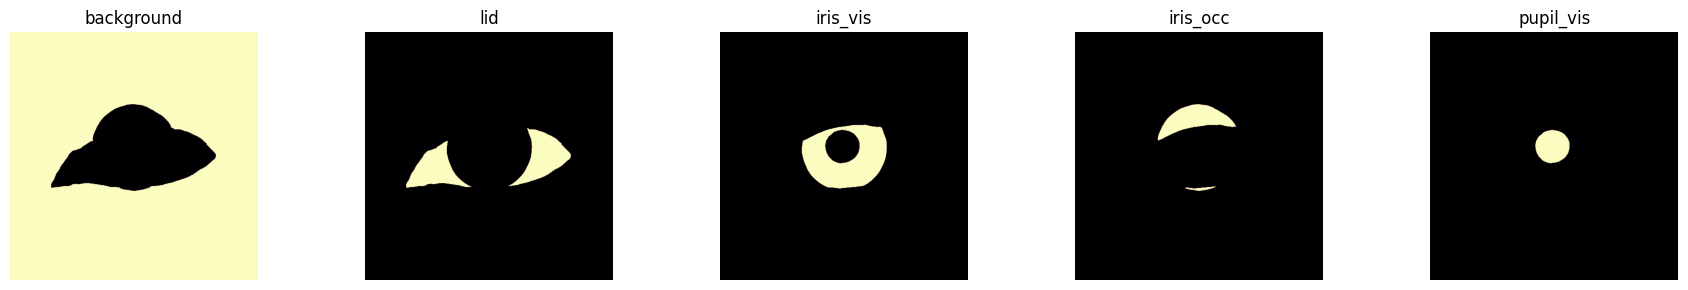

In [ ]:
# 予測クラス分布と各クラス確率マップの診断
with torch.no_grad():
    pred = model3(sample_image)
    prob = pred['five_class_seg'][0].cpu()  # (C,H,W)
    pred_class = torch.argmax(prob, dim=0)

# 出現クラス一覧（クラス名付き）
class_names = {0: 'background', 1: 'lid', 2: 'iris_vis', 3: 'iris_occ', 4: 'pupil_vis', 5: 'pupil_occ'}
unique_classes, counts = torch.unique(pred_class, return_counts=True)
print("Pred unique classes:", {class_names[int(k)]: int(v) for k,v in zip(unique_classes, counts)})

# 各クラスの確率統計（クラス名付き）
stats = {}
for c in range(5):
    pc = prob[c]
    stats[class_names[c]] = {
        'min': float(pc.min()),
        'max': float(pc.max()),
        'mean': float(pc.mean())
    }
print("Class prob stats:", stats)

# 可視化（確率ヒートマップ、クラス名タイトル）
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for c in range(5):
    axes[c].imshow(prob[c], cmap='magma', vmin=0, vmax=1)
    axes[c].set_title(class_names[c])
    axes[c].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# 可視化用のデータ準備
# 画像を表示用に変換（Denormalize）
image_denorm = sample_batch['image'][0].cpu().clone()
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
image_denorm = image_denorm * std[:, None, None] + mean[:, None, None]
image_denorm = torch.clamp(image_denorm, 0, 1)
image_denorm = image_denorm.permute(1, 2, 0).numpy()

# 正解マスクを構築（mask_lid、mask_iris、mask_pupilから6クラスGTを生成）
lid = sample_target['mask_lid'][0].cpu() > 0
iris = sample_target['mask_iris'][0].cpu() > 0
pupil = sample_target['mask_pupil'][0].cpu() > 0

target_label = torch.zeros((lid.shape[0], lid.shape[1]), dtype=torch.long)
target_label[lid & ~iris & ~pupil] = 1  # conj
target_label[lid &  iris & ~pupil] = 2  # iris_vis
target_label[~lid &  iris & ~pupil] = 3  # iris_occ
target_label[lid &  iris &  pupil] = 4   # pupil_vis
target_label[~lid &  iris &  pupil] = 5  # pupil_occ
# background (0) は既にゼロ

# カラーマップ（クラス → 色、6クラス対応）
colormap = {
    0: [0, 0, 0],        # background: 黒
    1: [255, 0, 0],      # conj: 赤
    2: [0, 255, 0],      # iris_vis: 緑
    3: [0, 0, 255],      # iris_occ: 青
    4: [255, 255, 0],    # pupil_vis: 黄
    5: [255, 0, 255],    # pupil_occ: マゼンタ
}

# torch.Tensorをnumpy配列に変換
pred_class_np = pred_class.numpy() if isinstance(pred_class, torch.Tensor) else pred_class
target_label_np = target_label.numpy() if isinstance(target_label, torch.Tensor) else target_label

# 予測マスクを色付け
pred_vis = np.zeros((pred_class_np.shape[0], pred_class_np.shape[1], 3), dtype=np.uint8)
for cls in range(6):
    pred_vis[pred_class_np == cls] = colormap.get(cls, [0, 0, 0])

# 正解マスクを色付け
target_vis = np.zeros((target_label_np.shape[0], target_label_np.shape[1], 3), dtype=np.uint8)
for cls in range(6):
    target_vis[target_label_np == cls] = colormap.get(cls, [0, 0, 0])

print("可視化用データ準備完了")


可視化用データ準備完了


In [ ]:
# dice係数の安全版（reshape対応）に再定義

def dice_coeff(pred, target, smooth=1e-5):
    """Dice係数（非連続テンソルでも安全に計算）"""
    pred_flat = pred.reshape(-1)
    target_flat = target.reshape(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    return (2.0 * intersection + smooth) / (union + smooth)


def dice_loss(pred, target):
    return 1 - dice_coeff(pred, target)

print("dice_coeff/dice_loss をreshape対応で再定義しました")


dice_coeff/dice_loss をreshape対応で再定義しました


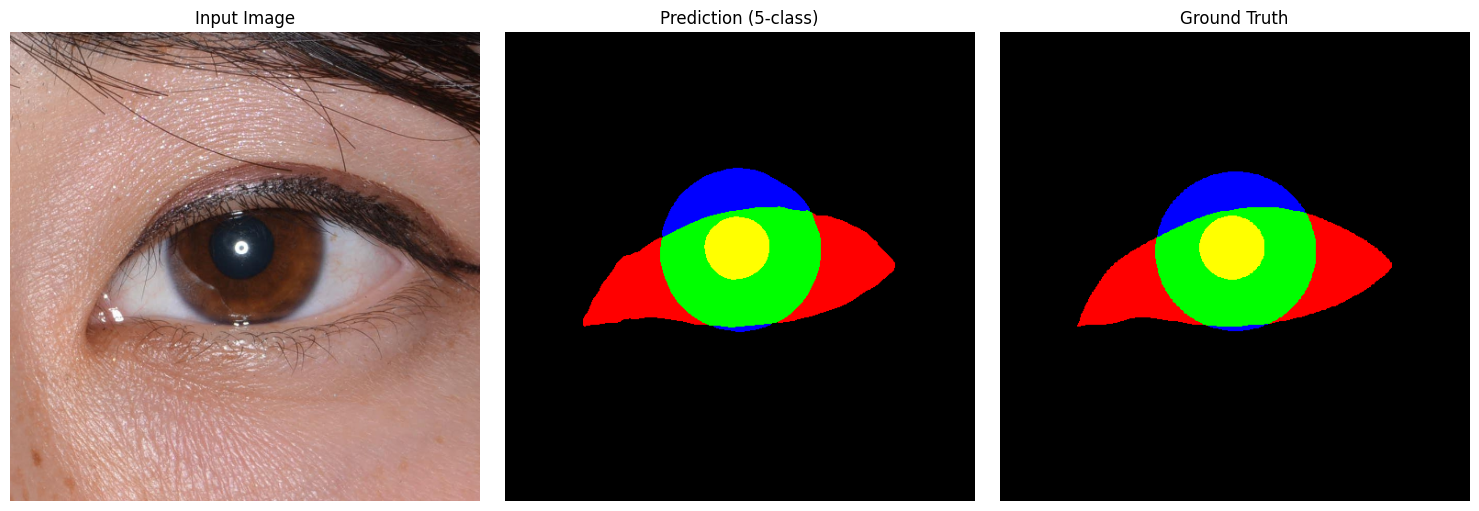

可視化画像を保存しました: visualization.png


In [ ]:
# 可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_denorm)
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(pred_vis)
axes[1].set_title('Prediction (5-class)')
axes[1].axis('off')

axes[2].imshow(target_vis)
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("可視化画像を保存しました: visualization.png")


In [ ]:
# クラス別Dice係数を計算
def compute_class_dice(pred, target, num_classes=6):
    """クラス別Dice係数"""
    dice_scores = {}
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        
        if union > 0:
            dice = (2.0 * intersection) / union
            dice_scores[cls] = dice.item()
        else:
            dice_scores[cls] = 0.0
    
    return dice_scores

# Dice係数を計算
dice_scores = compute_class_dice(pred_class, target_label, num_classes=6)

# 結果を表示
print("\n=== クラス別Dice係数 ===")
class_names = {0: 'background', 1: 'lid', 2: 'iris_vis', 3: 'iris_occ', 4: 'pupil_vis', 5: 'pupil_occ'}
for cls, name in class_names.items():
    print(f"{name}: {dice_scores[cls]:.4f}")

mean_dice = np.mean(list(dice_scores.values()))
print(f"\n平均Dice: {mean_dice:.4f}")



=== クラス別Dice係数 ===
background: 0.9975
lid: 0.9707
iris_vis: 0.9895
iris_occ: 0.9489
pupil_vis: 0.9847
pupil_occ: 0.0000

平均Dice: 0.8152


In [ ]:
# 検証データ全体でDice係数を計算
def evaluate_on_val_set(model, val_loader, device, num_samples=10):
    """検証セットで評価（サンプル数限定）"""
    model.eval()
    all_dice_scores = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= num_samples:
                break
            
            image = batch['image'].to(device)
            sample_target = {
                'mask_lid': batch['mask_lid'].to(device),
                'mask_iris': batch['mask_iris'].to(device),
                'mask_pupil': batch['mask_pupil'].to(device),
            }
            
            # 推論
            pred = model(image)
            pred_seg = pred['five_class_seg']
            pred_class = torch.argmax(pred_seg, dim=1)
            
            # 正解ラベル構築
            for b in range(pred_class.shape[0]):
                target_label = torch.zeros((pred_class.shape[1], pred_class.shape[2]), 
                                          dtype=torch.long, device=device)
                lid = sample_target['mask_lid'][b] > 0
                iris = sample_target['mask_iris'][b] > 0
                pupil = sample_target['mask_pupil'][b] > 0
                
                # 6クラス構築
                target_label[lid & ~iris & ~pupil] = 1  # conj相当
                target_label[(~lid) & iris & (~pupil)] = 3  # iris_occ
                target_label[(lid) & iris & (~pupil)] = 2   # iris_vis
                target_label[(~lid) & iris & pupil] = 5     # pupil_occ
                target_label[(lid) & iris & pupil] = 4      # pupil_vis
                
                # Dice係数を計算
                dice_scores = compute_class_dice(pred_class[b].cpu(), target_label.cpu(), num_classes=6)
                for cls in range(6):
                    all_dice_scores[cls].append(dice_scores[cls])
    
    # 平均値を計算
    mean_scores = {cls: np.mean(scores) for cls, scores in all_dice_scores.items()}
    return mean_scores

# 検証セットで評価
print("\n検証セットで評価中...")
val_dice_scores = evaluate_on_val_set(model3, val_loader, device, num_samples=10)

print("\n=== 検証セットでの平均Dice係数 ===")
for cls, name in class_names.items():
    print(f"{name}: {val_dice_scores[cls]:.4f}")

mean_dice_val = np.mean(list(val_dice_scores.values()))
print(f"\n全体平均Dice: {mean_dice_val:.4f}")



検証セットで評価中...
Please run the first cell of process_data.ipynb to generate sixcls labels!

=== 検証セットでの平均Dice係数 ===
background: 0.9952
lid: 0.9506
iris_vis: 0.9443
iris_occ: 0.8351
pupil_vis: 0.9022
pupil_occ: 0.0671

全体平均Dice: 0.7824


Samples: [327, 57, 12]


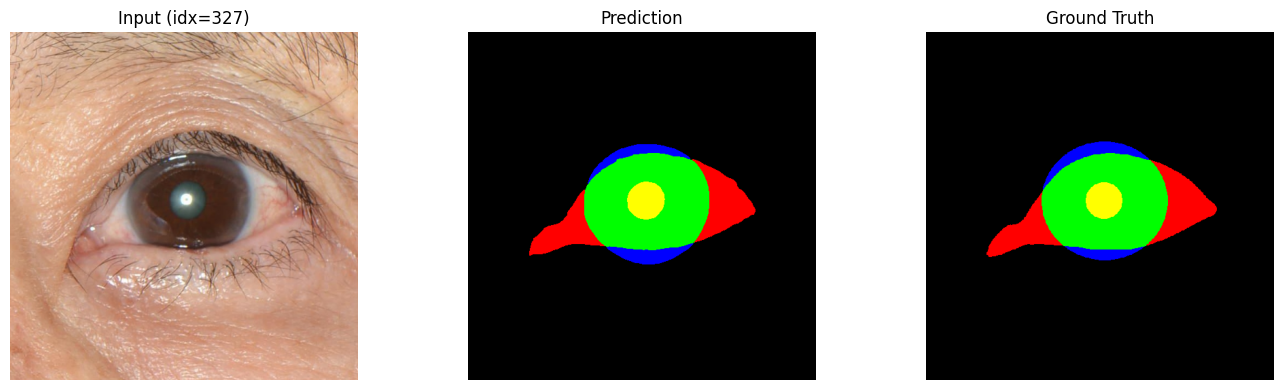

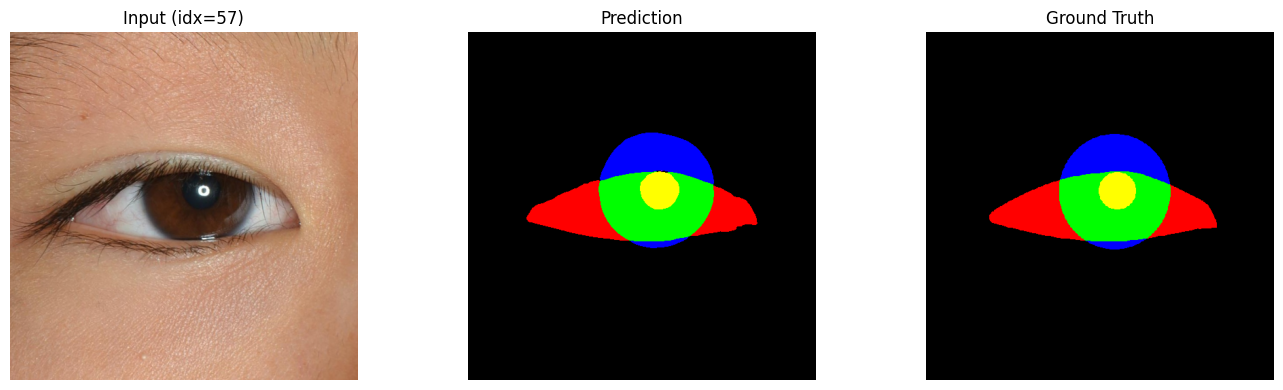

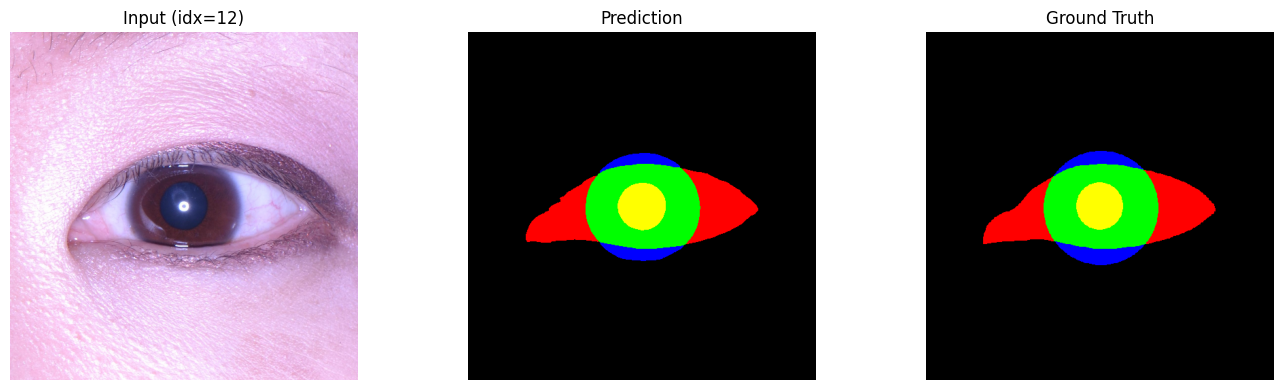

In [ ]:
# ランダムな検証画像で推論・可視化するユーティリティ
import random

def infer_random_samples(model, dataset, device, num_samples=3, seed=None):
    if seed is not None:
        random.seed(seed)
    model.eval()
    indices = random.sample(range(len(dataset)), k=min(num_samples, len(dataset)))
    print(f"Samples: {indices}")

    for i, idx in enumerate(indices):
        sample = dataset[idx]
        image = sample['image'].unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(image)
            prob = out['five_class_seg'][0].cpu()  # (C,H,W)
            pred_class = torch.argmax(prob, dim=0)

        # GTラベル（mask_lid、mask_iris、mask_pupilから6クラスGTを生成）
        lid = sample['mask_lid'] > 0
        iris = sample['mask_iris'] > 0
        pupil = sample['mask_pupil'] > 0
        
        target_label = torch.zeros_like(pred_class, dtype=torch.long)
        target_label[lid & ~iris & ~pupil] = 1  # conj
        target_label[lid &  iris & ~pupil] = 2  # iris_vis
        target_label[~lid &  iris & ~pupil] = 3  # iris_occ
        target_label[lid &  iris &  pupil] = 4   # pupil_vis
        target_label[~lid &  iris &  pupil] = 5  # pupil_occ
        # background (0) は既にゼロ

        # 入力画像のデノーマライズ
        img = sample['image'].cpu().clone()
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std[:, None, None] + mean[:, None, None]
        img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

        # カラーマップ
        colormap = {
            0: [0, 0, 0],        # background
            1: [255, 0, 0],      # lid / conj内を含む
            2: [0, 255, 0],      # iris_vis
            3: [0, 0, 255],      # iris_occ
            4: [255, 255, 0],    # pupil_vis
            5: [255, 0, 255],    # pupil_occ
        }

        # 可視化画像作成（torch.Tensorをnumpy配列に変換）
        pred_class_np = pred_class.numpy() if isinstance(pred_class, torch.Tensor) else pred_class
        target_label_np = target_label.numpy() if isinstance(target_label, torch.Tensor) else target_label
        
        pred_vis = np.zeros((pred_class_np.shape[0], pred_class_np.shape[1], 3), dtype=np.uint8)
        tgt_vis = np.zeros((target_label_np.shape[0], target_label_np.shape[1], 3), dtype=np.uint8)
        for cls in range(6):
            pred_vis[pred_class_np == cls] = colormap.get(cls, [0, 0, 0])
            tgt_vis[target_label_np == cls] = colormap.get(cls, [0, 0, 0])

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        axes[0].imshow(img); axes[0].set_title(f'Input (idx={idx})'); axes[0].axis('off')
        axes[1].imshow(pred_vis); axes[1].set_title('Prediction'); axes[1].axis('off')
        axes[2].imshow(tgt_vis); axes[2].set_title('Ground Truth'); axes[2].axis('off')
        plt.tight_layout()
        plt.show()

# 実行例（検証データからランダムに3枚）
infer_random_samples(model3, val_dataset, device, num_samples=3, seed=GLOBAL_SEED)


## 学習ループの実装

各foldで3手法の学習を実行：
- AdamW最適化（lr=1e-3, wd=1e-4）
- Cosine decay
- Early stopping（patience=30）
- AMP有効
- fold別にモデルを保存


In [ ]:
# TODO: 学習ループの実装
# TODO: 各foldでのtrain/val分割
# TODO: 3手法の順次学習
# TODO: 評価（Dice係数）と保存

print("学習ループの実装が必要です")


学習ループの実装が必要です
